### BigMart Sales Prediction Using XGBOOST, RandomForestRegressor & LinearRegressor

In [ ]:
pip install xgboost

In [3]:
## Import necessary libraries


import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit , RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [5]:
## Load Data from local drive

from google.colab import files
import io
uploaded = files.upload()

df1 = pd.read_csv(io.StringIO(uploaded['BigMartData.csv'].decode('utf-8')))


Saving BigMartData.csv to BigMartData.csv


In [6]:
df1.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


#### Perform EDA & Data Preprocessing

In [7]:
df1.shape

(8523, 12)

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [9]:
### Check for NULL values


df1.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

#### Handling Missing Values

In [10]:
# Find the mean of "Item_weight" column

df1['Item_Weight'].mean()

12.857645184136183

In [11]:
# Fill Missing Values in "Item_weight" with Mean values

df1['Item_Weight'].fillna(df1['Item_Weight'].mean(), inplace = True)

In [13]:
df1['Item_Weight'].isnull().sum()

0

In [14]:
# Find Mode of "Outlet_Size" column

df1['Outlet_Size'].mode()

0    Medium
dtype: object

In [15]:
# Fill the missing values in "Outlet_Size" column with Mode

mode = df1.pivot_table(values='Outlet_Size', columns='Outlet_Type', aggfunc=(lambda x: x.mode()[0]))

In [16]:
print(mode)

Outlet_Type Grocery Store Supermarket Type1 Supermarket Type2 Supermarket Type3
Outlet_Size         Small             Small            Medium            Medium


In [17]:
missing = df1['Outlet_Size'].isnull()

print(missing)

0       False
1       False
2       False
3        True
4       False
        ...  
8518    False
8519     True
8520    False
8521    False
8522    False
Name: Outlet_Size, Length: 8523, dtype: bool


In [18]:
df1.loc[missing, 'Outlet_Size'] = df1.loc[missing,'Outlet_Type'].apply(lambda x: mode[x])

In [19]:
### Check for NULL values

df1.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [20]:
df1.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


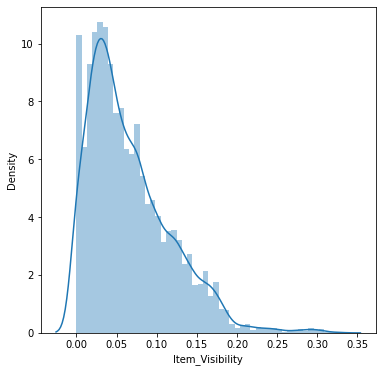

In [21]:
# Visualise Item_Visibility distribution

plt.figure(figsize=(6,6))
sns.distplot(df1['Item_Visibility'])
plt.show()

# Positive Skew

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


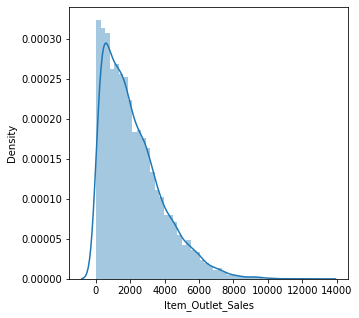

In [22]:
# Visualise Item_Outlet_Sales distribution

plt.figure(figsize=(5,5))
sns.distplot(df1['Item_Outlet_Sales'])
plt.show()

# Positive Skew

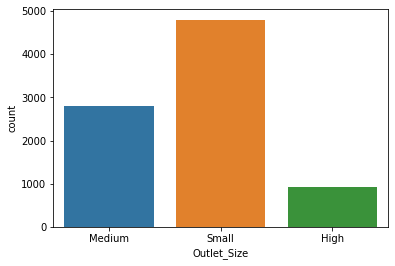

In [23]:
# Visualise Outlet_Size column

sns.countplot(x='Outlet_Size', data=df1)
plt.show()

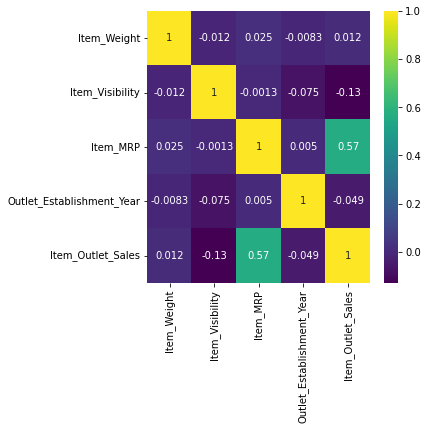

In [24]:
## Visualize Correlation using heatmap. Numerical Column

plt.figure(figsize=(5,5))
sns.heatmap(df1.corr(),annot=True,cmap='viridis')
plt.show()

In [25]:
df1.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [26]:
### Convert column Dtype to integer.

df1['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [27]:
# Edit Low Fat as LF, low fat

df1.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [28]:
### Convert column Dtype to integer

df1['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [29]:
# Low Fat = 0
# Regular = 1

def ref(x):
  if x == 'Low Fat':
    return 0
  else:
    return 1

df1['Item_Fat_Content'] = df1['Item_Fat_Content'].map(ref)

In [30]:
df1.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


In [31]:
df1['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [32]:
## Edit Column Dtype by removing the strings

def ref(x) :
  if x == 'Supermarket Type1':
    return 1
  elif x == 'Grocery Store':
    return 0
  elif x == 'Supermarket Type3':
    return 3
  else:
    return 2


df1['Outlet_Type'] = df1['Outlet_Type'].map(ref)

In [33]:
df1['Outlet_Type'].value_counts()

1    5577
0    1083
3     935
2     928
Name: Outlet_Type, dtype: int64

In [34]:
df1['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [35]:
## Edit Column Dtype by removing the strings

def ab(x) :
  if x == 'Tier 1':
    return 1
  elif x == 'Tier 2':
    return 2
  else:
    return 3

df1['Outlet_Location_Type'] = df1['Outlet_Location_Type'].map(ab)

In [36]:
df1['Outlet_Location_Type'].value_counts()

3    3350
2    2785
1    2388
Name: Outlet_Location_Type, dtype: int64

In [38]:
df1['Outlet_Size'].value_counts()

Small     4798
Medium    2793
High       932
Name: Outlet_Size, dtype: int64

In [39]:
## Edit Column Dtype by removing the strings

def ab(x) :
  if x == 'Small':
    return 1
  elif x == 'Medium':
    return 2
  else:
    return 3

df1['Outlet_Size'] = df1['Outlet_Size'].map(ab)

In [40]:
df1['Outlet_Size'].value_counts()

1    4798
2    2793
3     932
Name: Outlet_Size, dtype: int64

In [42]:
df1['Item_Identifier'].value_counts()

FDG33    10
FDW13    10
FDT07     9
FDO19     9
FDV60     9
         ..
FDO33     1
FDQ60     1
FDC23     1
FDN52     1
FDE52     1
Name: Item_Identifier, Length: 1559, dtype: int64

In [43]:
df1['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [41]:
df1.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,2,1,1,3735.1380
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2009,2,3,2,443.4228
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,2,1,1,2097.2700
3,FDX07,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,1,3,0,732.3800
4,NCD19,8.93,0,0.000000,Household,53.8614,OUT013,1987,3,3,1,994.7052


#### Label Encoding

In [44]:
### Convert remaining 3 Columns to Integers

encoder = LabelEncoder()

In [45]:
df1['Item_Identifier'] = encoder.fit_transform(df1['Item_Identifier'])

df1['Item_Type'] = encoder.fit_transform(df1['Item_Type'])

df1['Outlet_Identifier'] = encoder.fit_transform(df1['Outlet_Identifier'])


In [46]:
df1.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,2,1,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,2,3,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,2,1,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,1,3,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,3,3,1,994.7052


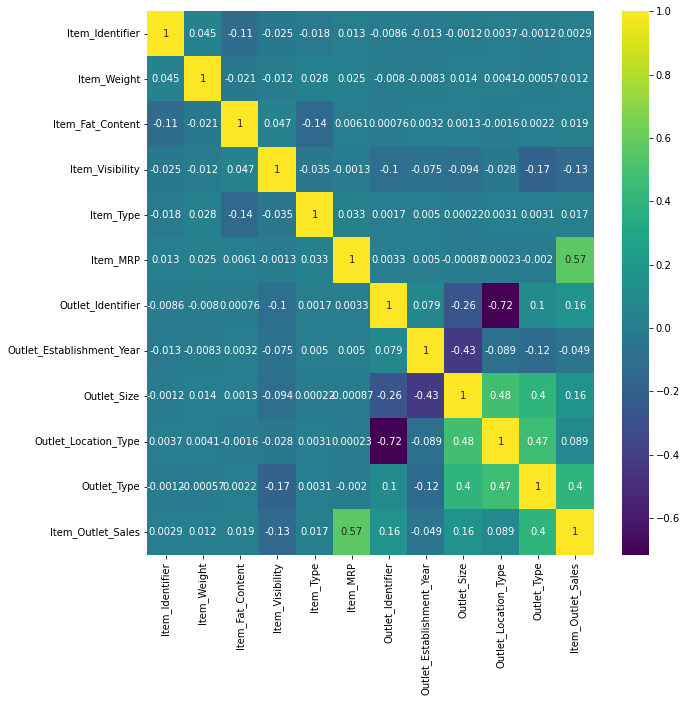

In [48]:
## Visualize Correlation using Heatmap

plt.figure(figsize=(10,10))
sns.heatmap(df1.corr(),annot=True,cmap='viridis')
plt.show()


Split Data into Dependent & Independent


In [49]:
X = df1.drop(columns='Item_Outlet_Sales', axis=1)

Y = df1['Item_Outlet_Sales']

Split the data into Training & Testing Data

In [50]:

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=2)


In [51]:
print(X.shape, Xtrain.shape, Xtest.shape)

(8523, 11) (6818, 11) (1705, 11)


Using XGBRegressor ML Model

In [52]:
regressor = XGBRegressor()

In [53]:
regressor.fit(Xtrain, Ytrain)

[11:30:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [54]:
# prediction on training data

pred = regressor.predict(Xtrain)

In [55]:
# prediction on test data

test_pred = regressor.predict(Xtest)

In [57]:

### Check the accuracy for Train

regressor_accuracy = round(regressor.score(Xtrain, Ytrain)*100,2)

print(round(regressor_accuracy, 2), '%')

63.64 %


In [58]:
### Check the accuracy for Test

regressor_accuracy1 = round(regressor.score(Xtest, Ytest)*100,2)

print(round(regressor_accuracy1, 2), '%')

58.68 %


In [69]:
# prediction on training data

training_data_prediction = regressor.predict(Xtrain)

In [72]:
# Check R squared Value

r2_train = metrics.r2_score(Ytrain, training_data_prediction)

In [73]:
print('R Squared value = ', r2_train)

R Squared value =  0.6364457030941357


Using RandomForestRegressor ML Model


In [62]:
random_model = RandomForestRegressor(n_estimators=300, random_state = 42, n_jobs = -1)


In [64]:
### Predict Data

random_model.fit(Xtrain, Ytrain)

RFR_pred = random_model.predict(Xtest)

print(RFR_pred)


[2461.16077067 2626.46337533 1614.911216   ... 2829.81866933 2972.53068
 3467.70167533]


In [65]:
### Check the accuracy for Train

random_model_accuracy = round(random_model.score(Xtrain, Ytrain)*100,2)

print(round(random_model_accuracy, 2), '%')

93.99 %


In [75]:
### Check the accuracy for Test

random_model_accuracy1 = round(random_model.score(Xtest, Ytest)*100,2)

print(round(random_model_accuracy1, 2), '%')

55.51 %


In [77]:
### Check R Squared Value

r2_score(RFR_pred, Ytest)

0.2674573933176254

In [78]:
### Display Actual and Predicted Data

pd.DataFrame(np.c_[Ytest , RFR_pred], columns = ['Actual' , 'Predicted'])

,Actual,Predicted
0,1544.6560,2461.160771
1,6404.9960,2626.463375
2,1070.6064,1614.911216
3,369.5190,263.075335
4,101.2016,237.038116
...,...,...
1700,4255.7936,3701.151129
1701,1222.4088,661.765252
1702,1551.9798,2829.818669
1703,3068.0064,2972.530680


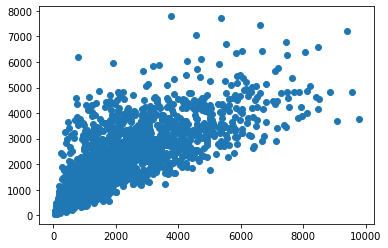

In [79]:
### Visualize Actual & Predicted Data


plt.scatter(Ytest, RFR_pred)

plt.show()

Using Linear Regression Model

In [83]:
### Using Linear Regression Model

reg = LinearRegression()

reg.fit(Xtrain, Ytrain)

LinearRegression()

In [84]:
### Training

print(round(reg.score(Xtrain, Ytrain), 2))

0.51


In [85]:
### Testing

print(round(reg.score(Xtest, Ytest), 2))

0.49
